# Classical Shadow Transformer

## Initialization

In [1]:
from CST import *
import matplotlib.pyplot as plt
import pickle
import torch
# 'cpu', 'cuda', 'mps' ..
device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
print(device)


cuda


## Testing

### Transformer

#### Test 1: Log Probability Estimation

**Goal:** show that the log probability accumulated at sampling is the same as log probability evaluated by the model directly.

Create a model and put into evaluation mode (to disable dropout).

In [2]:
tf = Transformer(outtk_size=2)
tf.eval()
x = torch.tensor([[4], [4], [5], [5], [6], [6]])


In [3]:
y, logprob = tf.sample(x, 1, need_logprob=True)
y, logprob


(tensor([[1],
         [1],
         [1],
         [1],
         [1],
         [1]]),
 tensor([-0.3080, -0.3080, -0.3540, -0.3540, -0.2757, -0.2757]))

In [4]:
tf.logprob(x, y)


tensor([-0.3080, -0.3080, -0.3540, -0.3540, -0.2757, -0.2757],
       grad_fn=<SumBackward1>)

Results are matched up.

#### Test 2: Generative Modeling

**Goal:** test the ability of the transformer model to learn sequence-to-sequence map.

In [5]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4], [4], [5], [5], [6], [6], [6]])
y = torch.tensor([[1], [1], [1], [2], [1], [2], [2]])
y1 = torch.tensor([[1], [2], [1], [2], [1], [2], [2]])


In [6]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)


In [7]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss = -tf.logprob(x, y).mean()
    loss.backward()
    optimizer.step()
    print('{:3d}: {:8.5g}'.format(epoch, loss.item()))


  0:  0.91667
  1:   0.6877
  2:  0.67112
  3:  0.68027
  4:  0.62687
  5:  0.57541
  6:  0.53083
  7:  0.53451
  8:  0.52557
  9:  0.53189


Learns to predict $y$ from $x$.

In [8]:
tf.eval()
tf.logprob(x, y1).exp().tolist()


[0.8856273293495178,
 0.11437271535396576,
 0.4303962290287018,
 0.5696037411689758,
 0.19486749172210693,
 0.8051325082778931,
 0.8051325082778931]

#### Test 3: VAE loss

**Goal**: test training the transformer with VAE bottleneck

In [9]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4], [4], [5], [5], [6], [6], [6]])
y = torch.tensor([[1], [1], [1], [2], [1], [2], [2]])
y1 = torch.tensor([[1], [2], [1], [2], [1], [2], [2]])


In [10]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)


In [11]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss, logprob, kld = tf.loss(x, y, beta=0.)
    loss.backward()
    optimizer.step()
    print(f'{epoch:3d}: {loss.item():8.5g} {logprob.item():8.5g} {kld.item():8.5g}')


  0:  0.82444 -0.82444   1.3279
  1:  0.68361 -0.68361   1.3192
  2:  0.62123 -0.62123   1.3052
  3:  0.63004 -0.63004   1.3098
  4:  0.66798 -0.66798    1.297
  5:  0.60514 -0.60514   1.3065
  6:  0.59566 -0.59566   1.3247
  7:  0.54796 -0.54796   1.3381
  8:  0.51245 -0.51245   1.3604
  9:  0.55732 -0.55732   1.3564


Learns to predict $y$ from $x$.

In [12]:
tf.eval()
tf.logprob(x, y1).exp().tolist()


[0.9116949439048767,
 0.0883050411939621,
 0.5478711128234863,
 0.4521288573741913,
 0.23459886014461517,
 0.7654011845588684,
 0.7654011249542236]

Now the accuracy can be controlled by the hyperparameter $\beta$.

#### Test 4: Sampling

**Goal**: test sampling and completion.

In [13]:
tf = Transformer(outtk_size=2)
x = torch.randint(4, 7, (3, 5))
tf.sample(x)


tensor([[2, 2, 2, 2],
        [1, 2, 2, 1],
        [1, 2, 2, 2]])

Completion task.

In [14]:
y = torch.randint(1, 3, (3, 2))
y


tensor([[1, 2],
        [2, 2],
        [1, 2]])

In [15]:
tf.sample(x, tgt_seq=y)


tensor([[1, 2, 1, 2],
        [2, 2, 2, 2],
        [1, 2, 2, 1]])

### Operator

#### Test 1: Operator Algebra

**Goal:** test operator algebra are correct

In [16]:
ops = [pauli([i]) for i in range(4)]
ops


[I, X, Y, Z]

Multiplication table of Pauli operators

In [17]:
for op1 in ops:
    for op2 in ops:
        print(f'{op1} @ {op2} = {op1 @ op2}')


I @ I = I
I @ X = X
I @ Y = Y
I @ Z = Z
X @ I = X
X @ X = I
X @ Y = i Z
X @ Z = -i Y
Y @ I = Y
Y @ X = -i Z
Y @ Y = I
Y @ Z = i X
Z @ I = Z
Z @ X = i Y
Z @ Y = -i X
Z @ Z = I


#### Test 2: Operator Gradient

Example: construct an operator

In [18]:
O = pauli('X') + 1j * pauli('Y') - 2 * pauli('Z')
O


X + i Y -2 Z

In [19]:
O = O.requires_grad_()
O


X + i Y -2 Z (requires_grad=True)

In [20]:
O.H @ O


6 I -4 X -2 Z (grad_fn=<class 'IndexBackward0'>)

Operator norm is defined to be $\Vert O\Vert^2=\mathrm{Tr}\,O^\dagger O$

In [21]:
O.norm()


tensor(6., grad_fn=<SelectBackward0>)

In [22]:
O.norm().backward()
O.grad


2 X + (0.00+2.00i) Y -4 Z

### Shadow

#### Test 1: Shadow Evaluate 

**Goal:** evaluate operator expectation value on a shadow dataset.

In [23]:
shd = ghz_shadow(3, 1000)
shd


| -Z -Y -Z |
| -Z -X +Y |
| +Y +Y -X |
| -Y -X -Y |
| -Y -Y -X |
| -X +Z +Z |
| -X +Z -X |
| +Y +Y -Z |
| -Y -X -Y |
| -Y +Z -X |
| +Z -X +Y |
| -X +X +Y |
| -X -X +Z |
| -Z -Z -X |
| -X +Z +X |
| +Z -Y +Z |
...

In [24]:
pauli('ZZI').expectation(shd)


tensor(0.9900+0.j)

### ClassicalShadowTransformer

#### Test 1: Sampling

**Goal**: test sampling and state reconstruction

In [25]:
cst = ClassicalShadowTransformer(2, 0)
cst.sample(6)


| -Y +Y |
| -Y -X |
| -Z -Z |
| -X -Z |
| -X -Z |
| -Z +Z |

Reconstruct density operator (matrix).

In [26]:
rho = cst.rho()
rho


1.00 II -0.17 IX -0.18 IY -0.19 IZ -0.36 XI + 0.12 XX + 0.15 XY + 0.14 XZ -0.33 YI + 0.15 YX + 0.09 YY + 0.16 YZ -0.34 ZI + 0.12 ZX + 0.12 ZY + 0.12 ZZ (grad_fn=<class 'SqueezeBackward4'>)

In [27]:
rhomat = rho.matrix_form(2) / 2**2
rhomat


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
torch.linalg.eigvalsh(rhomat)


tensor([-0.1150,  0.0085,  0.3709,  0.7356], grad_fn=<LinalgEighBackward0>)

#### Test 2: Evaluation

**Goal**: test logprob and loss function evaluation.

In [ ]:
cst = ClassicalShadowTransformer(2, 0)
cst.eval()
shd = ghz_shadow(2, 10)


In [ ]:
cst.logprob(shd)


tensor([-1.7702, -1.0585, -1.7702, -1.6669, -1.0810, -1.8320, -1.1911, -1.6669,
        -1.2102, -1.7125], grad_fn=<SumBackward1>)

In [ ]:
cst.loss(shd)


(tensor(2.5820, grad_fn=<MeanBackward0>),
 tensor(-1.5054, grad_fn=<MeanBackward0>),
 tensor(1.0766, grad_fn=<MeanBackward0>))

## Training

### Batch Training

Scaning over parameter space and train a collection of models of different number of qubits and hyperparameter $\beta$. `max_steps` - maximal optimization step, `nsr` - the noise signal ratio threshold for the loss function flucturation (optimization stop when the noise signal ratio is larger than this threshold), `window` - the window size used to estimate noise signal ratio (larger window size stricter convergence criterion), `n_sample` - number of classical shadow samples used in each iteration, `lr` -  learning rate.

In [ ]:
for n_qubit in range(1, 7):
    for logbeta in range(-6, 7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).to(device).load()
        cst.optimize(3000, max_steps=30000, nsr=32, window=400,
                     n_sample=200, lr=0.0001, seed=42)


./model/CST_d64_h16_l1/GHZ_N1_b-6


 10%|█         | 3000/30000 [00:44<06:38, 67.74it/s]


./model/CST_d64_h16_l1/GHZ_N1_b-5


 10%|█         | 3000/30000 [00:53<08:00, 56.23it/s]


./model/CST_d64_h16_l1/GHZ_N1_b-4


 10%|█         | 3000/30000 [00:52<07:55, 56.83it/s]


./model/CST_d64_h16_l1/GHZ_N1_b-3


 10%|█         | 3000/30000 [00:52<07:54, 56.92it/s]


./model/CST_d64_h16_l1/GHZ_N1_b-2


 10%|█         | 3000/30000 [00:51<07:46, 57.83it/s]


./model/CST_d64_h16_l1/GHZ_N1_b-1


 10%|█         | 3000/30000 [00:51<07:44, 58.13it/s]


./model/CST_d64_h16_l1/GHZ_N1_b0


 10%|█         | 3000/30000 [00:51<07:45, 58.02it/s]


./model/CST_d64_h16_l1/GHZ_N1_b1


 10%|█         | 3000/30000 [00:52<07:54, 56.86it/s]


./model/CST_d64_h16_l1/GHZ_N1_b2


 10%|█         | 3000/30000 [00:52<07:54, 56.85it/s]


./model/CST_d64_h16_l1/GHZ_N1_b3


 10%|█         | 3001/30000 [00:52<07:54, 56.86it/s]


./model/CST_d64_h16_l1/GHZ_N1_b4


 10%|█         | 3000/30000 [00:54<08:11, 54.91it/s]


./model/CST_d64_h16_l1/GHZ_N1_b5


 10%|█         | 3000/30000 [00:52<07:49, 57.56it/s]


./model/CST_d64_h16_l1/GHZ_N1_b6


 10%|█         | 3000/30000 [00:31<04:45, 94.45it/s] 


./model/CST_d64_h16_l1/GHZ_N2_b-6


 10%|█         | 3000/30000 [00:32<04:51, 92.74it/s]


./model/CST_d64_h16_l1/GHZ_N2_b-5


 10%|█         | 3000/30000 [00:32<04:52, 92.38it/s]


./model/CST_d64_h16_l1/GHZ_N2_b-4


 10%|█         | 3000/30000 [00:32<04:51, 92.51it/s]


./model/CST_d64_h16_l1/GHZ_N2_b-3


 10%|█         | 3000/30000 [00:32<04:50, 92.85it/s]


./model/CST_d64_h16_l1/GHZ_N2_b-2


 10%|█         | 3000/30000 [00:32<04:50, 92.83it/s]


./model/CST_d64_h16_l1/GHZ_N2_b-1


 10%|█         | 3000/30000 [00:32<04:50, 92.90it/s]


./model/CST_d64_h16_l1/GHZ_N2_b0


 10%|█         | 3000/30000 [00:32<04:50, 92.89it/s]


./model/CST_d64_h16_l1/GHZ_N2_b1


 10%|█         | 3000/30000 [00:32<04:51, 92.72it/s]


./model/CST_d64_h16_l1/GHZ_N2_b2


 10%|█         | 3001/30000 [00:32<04:49, 93.12it/s]


./model/CST_d64_h16_l1/GHZ_N2_b3


 10%|█         | 3001/30000 [00:32<04:50, 92.96it/s]


./model/CST_d64_h16_l1/GHZ_N2_b4


 10%|█         | 3078/30000 [00:33<04:54, 91.38it/s]


./model/CST_d64_h16_l1/GHZ_N2_b5


 10%|█         | 3002/30000 [00:32<04:54, 91.70it/s]


./model/CST_d64_h16_l1/GHZ_N2_b6


 10%|█         | 3002/30000 [00:32<04:50, 92.96it/s]


./model/CST_d64_h16_l1/GHZ_N3_b-6


 10%|█         | 3000/30000 [00:32<04:54, 91.80it/s]


./model/CST_d64_h16_l1/GHZ_N3_b-5


 10%|█         | 3000/30000 [00:35<05:20, 84.20it/s]


./model/CST_d64_h16_l1/GHZ_N3_b-4


 10%|█         | 3000/30000 [00:32<04:52, 92.20it/s]


./model/CST_d64_h16_l1/GHZ_N3_b-3


 10%|█         | 3000/30000 [00:32<04:52, 92.41it/s]


./model/CST_d64_h16_l1/GHZ_N3_b-2


 10%|█         | 3000/30000 [00:32<04:53, 92.01it/s]


./model/CST_d64_h16_l1/GHZ_N3_b-1


 10%|█         | 3000/30000 [00:32<04:54, 91.53it/s]


./model/CST_d64_h16_l1/GHZ_N3_b0


 10%|█         | 3000/30000 [00:32<04:52, 92.25it/s]


./model/CST_d64_h16_l1/GHZ_N3_b1


 10%|█         | 3000/30000 [00:32<04:53, 92.05it/s]


./model/CST_d64_h16_l1/GHZ_N3_b2


 10%|█         | 3000/30000 [00:32<04:55, 91.38it/s]


./model/CST_d64_h16_l1/GHZ_N3_b3


 10%|█         | 3063/30000 [00:35<05:09, 86.94it/s]


./model/CST_d64_h16_l1/GHZ_N3_b4


 10%|█         | 3000/30000 [00:32<04:52, 92.37it/s]


./model/CST_d64_h16_l1/GHZ_N3_b5


 10%|█         | 3000/30000 [00:32<04:49, 93.15it/s]


./model/CST_d64_h16_l1/GHZ_N3_b6


 10%|█         | 3000/30000 [00:31<04:45, 94.41it/s]


./model/CST_d64_h16_l1/GHZ_N4_b-6


 10%|█         | 3000/30000 [00:33<04:57, 90.83it/s]


./model/CST_d64_h16_l1/GHZ_N4_b-5


 10%|█         | 3000/30000 [00:32<04:55, 91.29it/s]


./model/CST_d64_h16_l1/GHZ_N4_b-4


 10%|█         | 3000/30000 [00:32<04:55, 91.36it/s]


./model/CST_d64_h16_l1/GHZ_N4_b-3


 10%|█         | 3000/30000 [00:32<04:56, 91.18it/s]


./model/CST_d64_h16_l1/GHZ_N4_b-2


 10%|█         | 3000/30000 [00:32<04:55, 91.38it/s]


./model/CST_d64_h16_l1/GHZ_N4_b-1


 10%|█         | 3000/30000 [00:32<04:56, 91.13it/s]


./model/CST_d64_h16_l1/GHZ_N4_b0


 10%|█         | 3000/30000 [00:32<04:48, 93.66it/s]


./model/CST_d64_h16_l1/GHZ_N4_b1


 10%|█         | 3000/30000 [00:31<04:47, 93.91it/s]


./model/CST_d64_h16_l1/GHZ_N4_b2


 10%|█         | 3019/30000 [00:32<04:49, 93.27it/s]


./model/CST_d64_h16_l1/GHZ_N4_b3


 10%|█         | 3015/30000 [00:32<04:52, 92.41it/s]


./model/CST_d64_h16_l1/GHZ_N4_b4


 10%|█         | 3001/30000 [00:31<04:46, 94.26it/s]


./model/CST_d64_h16_l1/GHZ_N4_b5


 10%|█         | 3002/30000 [00:31<04:45, 94.47it/s]


./model/CST_d64_h16_l1/GHZ_N4_b6


 10%|█         | 3002/30000 [00:31<04:45, 94.72it/s]


./model/CST_d64_h16_l1/GHZ_N5_b-6


 10%|█         | 3000/30000 [00:34<05:11, 86.79it/s]


./model/CST_d64_h16_l1/GHZ_N5_b-5


 10%|█         | 3000/30000 [00:34<05:08, 87.56it/s]


./model/CST_d64_h16_l1/GHZ_N5_b-4


 10%|█         | 3000/30000 [00:32<04:56, 90.92it/s]


./model/CST_d64_h16_l1/GHZ_N5_b-3


 10%|█         | 3000/30000 [00:32<04:51, 92.66it/s]


./model/CST_d64_h16_l1/GHZ_N5_b-2


 10%|█         | 3000/30000 [00:32<04:56, 91.12it/s]


./model/CST_d64_h16_l1/GHZ_N5_b-1


 10%|█         | 3000/30000 [00:32<04:56, 91.13it/s]


./model/CST_d64_h16_l1/GHZ_N5_b0


 10%|█         | 3002/30000 [00:32<04:56, 91.15it/s]


./model/CST_d64_h16_l1/GHZ_N5_b1


 10%|█         | 3000/30000 [00:32<04:53, 91.86it/s]


./model/CST_d64_h16_l1/GHZ_N5_b2


 10%|█         | 3000/30000 [00:33<05:01, 89.67it/s]


./model/CST_d64_h16_l1/GHZ_N5_b3


 10%|█         | 3000/30000 [00:33<05:01, 89.65it/s]


./model/CST_d64_h16_l1/GHZ_N5_b4


 10%|█         | 3002/30000 [00:33<05:00, 89.83it/s]


./model/CST_d64_h16_l1/GHZ_N5_b5


 10%|█         | 3000/30000 [00:31<04:46, 94.23it/s]


./model/CST_d64_h16_l1/GHZ_N5_b6


 10%|█         | 3002/30000 [00:32<04:50, 93.05it/s]


./model/CST_d64_h16_l1/GHZ_N6_b-6


 10%|█         | 3000/30000 [00:37<05:33, 81.01it/s]


./model/CST_d64_h16_l1/GHZ_N6_b-5


 10%|█         | 3012/30000 [00:31<04:44, 94.70it/s]


./model/CST_d64_h16_l1/GHZ_N6_b-4


 10%|█         | 3000/30000 [00:31<04:44, 94.98it/s]


./model/CST_d64_h16_l1/GHZ_N6_b-3


 10%|█         | 3016/30000 [00:31<04:43, 95.14it/s]


./model/CST_d64_h16_l1/GHZ_N6_b-2


 10%|█         | 3014/30000 [00:31<04:44, 94.78it/s]


./model/CST_d64_h16_l1/GHZ_N6_b-1


 10%|█         | 3000/30000 [00:31<04:45, 94.71it/s]


./model/CST_d64_h16_l1/GHZ_N6_b0


 10%|█         | 3002/30000 [00:31<04:44, 94.87it/s]


./model/CST_d64_h16_l1/GHZ_N6_b1


 10%|█         | 3000/30000 [00:31<04:47, 93.91it/s]


./model/CST_d64_h16_l1/GHZ_N6_b2


 10%|█         | 3020/30000 [00:32<04:47, 93.71it/s]


./model/CST_d64_h16_l1/GHZ_N6_b3


 10%|█         | 3000/30000 [00:32<04:51, 92.57it/s]


./model/CST_d64_h16_l1/GHZ_N6_b4


 10%|█         | 3000/30000 [00:31<04:47, 93.81it/s]


./model/CST_d64_h16_l1/GHZ_N6_b5


 10%|█         | 3000/30000 [00:31<04:46, 94.11it/s]


./model/CST_d64_h16_l1/GHZ_N6_b6


 10%|█         | 3000/30000 [00:31<04:45, 94.60it/s]


Inspect loss history to determine convergence.

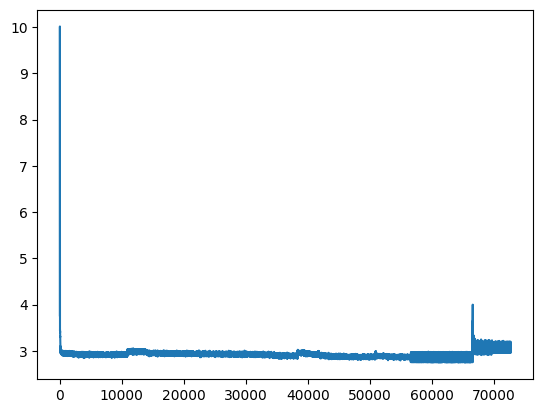

In [ ]:
cst = ClassicalShadowTransformer(5, -6).load()
# print(cst.transformer.repara.logvar)
plt.plot(cst.loss_history)


### Fine Tuning

If necessary, a model can be loaded for fine tuning with smaller training rate to ensure convergence.

In [ ]:
cst = ClassicalShadowTransformer(5, -6).load()


In [ ]:
cst.optimize(1000, max_steps=10000, nsr=32,
             window=1000, n_sample=1000, lr=0.00001)


./model/CST_d64_h16_l1/GHZ_N5_b-6
531:  2.87878 -2.87629  0.15949 -0.35431


KeyboardInterrupt: 

## Evaluation

### Loss Function History

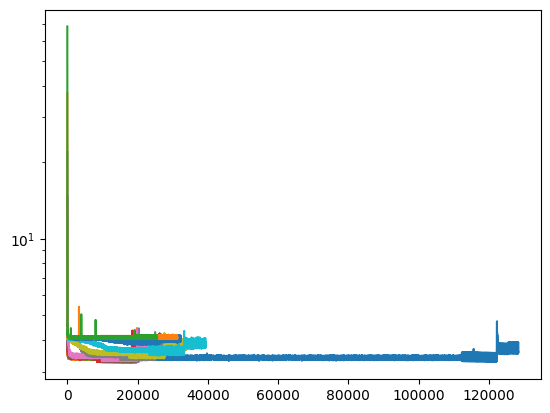

In [ ]:
for logbeta in range(-6, 7):
    cst = ClassicalShadowTransformer(6, logbeta).load()
    plt.plot(cst.loss_history)
    plt.yscale('log')


### Fidelity and Entropy Map

Compute fidelity and entropy (in unit of bit) of the reconstructed density matrix.

In [ ]:

import gc
gc.collect()
data = []


In [ ]:
import numpy as np
gc.collect()
for n_qubit in range(1, 7):
    for logbeta in tqdm(range(-6, 7)):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form(n_qubit)/2**cst.n_qubit  # reconstruction
        # compute fidelity
        fid = (rho[0, 0] + rho[-1, -1] + rho[0, -1] + rho[-1, 0])/2
        fid = fid.real.item()
        vals = np.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -np.log2(vals).dot(vals).item()
        clear_output(wait=True)
        print(cst.path + '/' + cst.file)
        print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, logbeta, fid, ent])
        gc.collect()

data


100%|██████████| 13/13 [04:54<00:00, 22.69s/it]

./model/CST_d64_h16_l1/GHZ_N6_b6
F = 0.04199595828686142, S = 5.341542699908009


[[1, -6, 0.9910753965377808, 0.07312440706411727],
 [1, -5, 0.9908692836761475, 0.07453809557815513],
 [1, -4, 0.9903708100318909, 0.07800407477847202],
 [1, -3, 0.991064578294754, 0.07298674096791487],
 [1, -2, 0.9907748401165009, 0.07477056835955484],
 [1, -1, 0.9903837442398071, 0.07779825134941627],
 [1, 0, 0.9905834496021271, 0.0763880870429962],
 [1, 1, 0.9906973540782928, 0.07555649708170077],
 [1, 2, 0.9899173676967621, 0.08079518296478619],
 [1, 3, 0.9854354858398438, 0.10853076357118537],
 [1, 4, 0.6651830524206161, 0.7495512960785679],
 [1, 5, 0.6649796664714813, 0.7495292284810663],
 [1, 6, 0.6644111424684525, 0.7513883363038043],
 [2, -6, 0.9327611923217773, 0.4436240163757069],
 [2, -5, 0.9311191588640213, 0.4555099166229002],
 [2, -4, 0.9356345236301422, 0.40697519999043197],
 [2, -3, 0.9342855662107468, 0.435499545810857],
 [2, -2, 0.9356059283018112, 0.41555232678496],
 [2, -1, 0.9347720593214035, 0.4154458851106199],
 [2, 0, 0.936346173286438, 0.42619842831447025],
 [

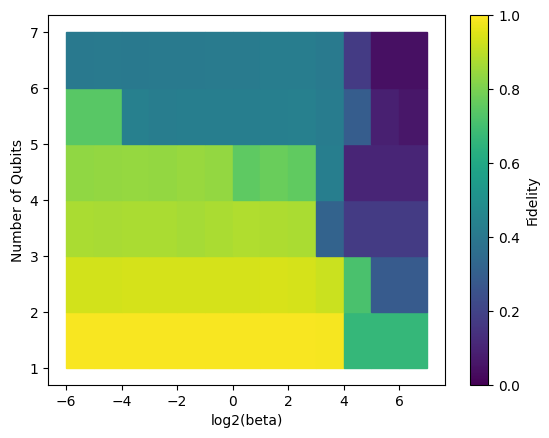

[[1, -6, 0.9910753965377808, 0.07312440706411727],
 [1, -5, 0.9908692836761475, 0.07453809557815513],
 [1, -4, 0.9903708100318909, 0.07800407477847202],
 [1, -3, 0.991064578294754, 0.07298674096791487],
 [1, -2, 0.9907748401165009, 0.07477056835955484],
 [1, -1, 0.9903837442398071, 0.07779825134941627],
 [1, 0, 0.9905834496021271, 0.0763880870429962],
 [1, 1, 0.9906973540782928, 0.07555649708170077],
 [1, 2, 0.9899173676967621, 0.08079518296478619],
 [1, 3, 0.9854354858398438, 0.10853076357118537],
 [1, 4, 0.6651830524206161, 0.7495512960785679],
 [1, 5, 0.6649796664714813, 0.7495292284810663],
 [1, 6, 0.6644111424684525, 0.7513883363038043],
 [2, -6, 0.9327611923217773, 0.4436240163757069],
 [2, -5, 0.9311191588640213, 0.4555099166229002],
 [2, -4, 0.9356345236301422, 0.40697519999043197],
 [2, -3, 0.9342855662107468, 0.435499545810857],
 [2, -2, 0.9356059283018112, 0.41555232678496],
 [2, -1, 0.9347720593214035, 0.4154458851106199],
 [2, 0, 0.936346173286438, 0.42619842831447025],
 [

In [ ]:
import numpy as np

x, y, z, _ = np.array(data).T
square_size = 1.0

fig, ax = plt.subplots()

for x, y, z in zip(y, x, z):
    square = plt.Rectangle((x, y), square_size,
                           square_size, color=plt.cm.viridis(z))
    ax.add_patch(square)


sc = plt.scatter([], [], c=[], cmap='viridis', s=100)
plt.colorbar(sc, label='Fidelity')
ax.set_ylabel('Number of Qubits')
ax.set_xlabel('log2(beta)')
plt.show()

data


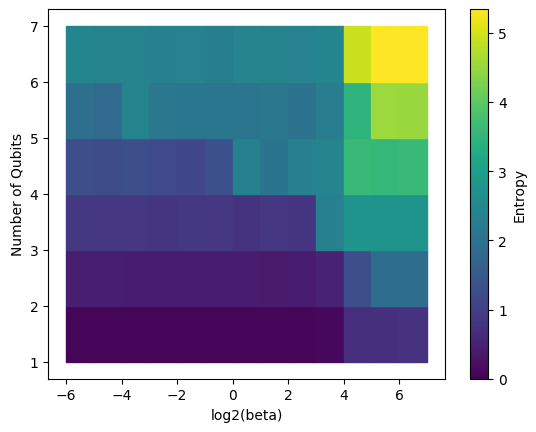

In [ ]:
import numpy as np

x, y, _, z = np.array(data).T
square_size = 1.0

max_z = np.max(z)
fig, ax = plt.subplots()

for x, y, z in zip(y, x, z):
    square = plt.Rectangle((x, y), square_size, square_size,
                           color=plt.cm.viridis(z/max_z))
    ax.add_patch(square)


sc = plt.scatter([], [], c=[], cmap='viridis', s=100, vmin=0, vmax=max_z)
plt.colorbar(sc, label='Entropy')
ax.set_ylabel('Number of Qubits')
ax.set_xlabel('log2(beta)')
plt.show()


TypeError: 'numpy.float64' object is not iterable

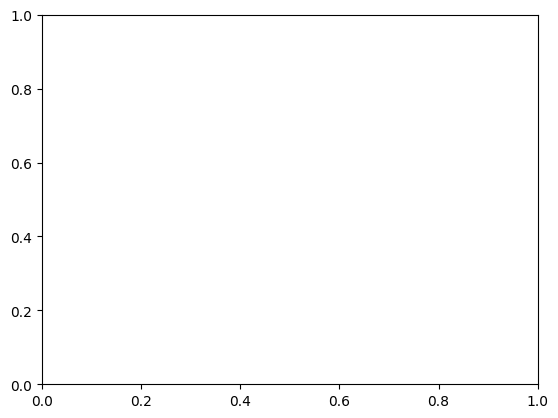

In [ ]:

fig, ax = plt.subplots()

for x, y, z in zip(x, y, z):
    square = plt.Rectangle((x - square_size / 2, y - square_size / 2),
                           square_size, square_size, color=plt.cm.viridis(z))
    ax.add_patch(square)


sc = plt.scatter([], [], c=[], cmap='viridis', s=100)
plt.colorbar(sc, label='Fidelity')
ax.set_xlabel('Number of Qubits')
ax.set_ylabel('log2(beta)')
plt.show()


In [ ]:
with open('./data/map.dat', 'wb') as f:
    pickle.dump(data, f)


Fidelity for 6 qubits (and beyond) can only be estimated by classical shadow tomography. First, prepare the GHZ state density matrix and convert it to Operator class.

In [ ]:
rho = qst.ghz_state(6).density_matrix
tok = rho.tokenize()
paulis = tok[:, :-1]
coeffs = (9.-2.*tok[:, -1]) * rho.cs
rho = Operator(torch.tensor(paulis), torch.tensor(coeffs))


Then evaluate the expectation value of the density matrix on the classical shadow ensemble.

In [ ]:
# data = []
for logbeta in range(2, 7):
    cst = ClassicalShadowTransformer(
        6, logbeta, embed_dim=128, n_layers=2).load().eval()
    clear_output(wait=True)
    print(cst.path + '/' + cst.file)
    fids = []
    for _ in range(5):
        shd = cst.sample(100000)
        fid = rho.expectation(shd, batch_size=1000).real.item()
        print(f'F = {fid:8.5f}')
        fids.append(fid)
    data.append([6, logbeta, fids])


./model/CST_d128_h16_l2/GHZ_N6_b6
F =  0.07216
F =  0.06822
F =  0.05655
F =  0.07230
F =  0.08284


In [ ]:
with open('./data/fid6_d128_l2.dat', 'wb') as f:
    pickle.dump(data, f)


### Atlas Boreas Cygnus

Take three representative models.

In [29]:
mdls = {
    'atlas': ClassicalShadowTransformer(5, -5).load().eval(),
    'boreas': ClassicalShadowTransformer(5, 0).load().eval(),
    'cygnus': ClassicalShadowTransformer(5, 6).load().eval()}


Chat with the model. Dictionary:

| Number | Symbol |
|--------|--------|
| `1`    | `+`    |
| `2`    | `-`    |
| `3`    | `I`    |
| `4`    | `X`    |
| `5`    | `Y`    |
| `6`    | `Z`    |

* Z-test: `x: ZZZZZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* X-test: `x: XXXXX, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* XZ-test: `x: XXXXZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 

Collect data:

In [ ]:
import numpy as np
obs = torch.tensor([[4, 4, 4, 4, 5,]])
out = torch.tensor([[1, 1, 1, 1, 0,]])
weight = []
with torch.no_grad():
    for name, model in mdls.items():
        logits = model.transformer(obs, out)[:, -1].numpy()
        exp = np.exp(logits)
        exp_sum = np.sum(exp)
        weight += [exp/exp_sum]

print(weight)
with open('./data/x_test.dat', 'rb') as f:
    data = pickle.load(f)
    print(data)


x = np.array([3.57879638671875, -5.147213459014893])
exp = np.exp(logits)
exp_sum = np.sum(exp)
np.sum(exp/exp_sum, axis=0)


[array([[0.5025073 , 0.49749267]], dtype=float32), array([[0.5149449, 0.4850551]], dtype=float32), array([[0.6616005 , 0.33839947]], dtype=float32)]
{'obs': [[1, 1, 1, 1], [1, 1, 1, 2], [1, 1, 2, 1], [1, 1, 2, 2], [1, 2, 1, 1], [1, 2, 1, 2], [1, 2, 2, 1], [1, 2, 2, 2], [2, 1, 1, 1], [2, 1, 1, 2], [2, 1, 2, 1], [2, 1, 2, 2], [2, 2, 1, 1], [2, 2, 1, 2], [2, 2, 2, 1], [2, 2, 2, 2]], 'atlas': [[3.453392744064331, -5.577329158782959], [-3.942599296569824, 4.460063934326172], [-4.212557792663574, 5.236018180847168], [3.5472140312194824, -5.406250953674316], [-4.176853656768799, 5.390142440795898], [3.4642531871795654, -5.549050331115723], [3.6229448318481445, -5.2573089599609375], [-3.831958770751953, 5.279883861541748], [-4.3733344078063965, 5.40889310836792], [3.7425689697265625, -5.188107967376709], [3.864804744720459, -5.2761640548706055], [-3.893472671508789, 5.17915153503418], [3.213273286819458, -5.231843948364258], [-3.933692216873169, 4.301440715789795], [-3.844228506088257, 5.45269

c:\Users\Kiki\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\attention.cpp:152.)
  return torch._native_multi_head_attention(


array([0.6616005 , 0.33839947], dtype=float32)

In [ ]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1, 2])]*4)
y = torch.cat([y0, torch.zeros(y.shape[0], dtype=torch.long)[:, None]], 1)
x = torch.zeros_like(y) + 4
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:, -1]
        data[name] = logit.tolist()
with open('./data/x_test.dat', 'wb') as f:
    pickle.dump(data, f)


IndexError: tuple index out of range

In [ ]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1, 2])]*4)
y = torch.cat([y0, torch.zeros(y.shape[0], dtype=torch.long)[:, None]], 1)
x = torch.zeros_like(y) + 4
x[:, -1] = 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:, -1]
        data[name] = logit.tolist()
with open('./data/xz_test.dat', 'wb') as f:
    pickle.dump(data, f)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 16 but got size 3 for tensor number 1 in the list.

### Density Matrix Reconstruction

Reconstruct density matrices for representative models.

In [ ]:
data = {}
for name, mdl in mdls.items():
    with torch.no_grad():
        rho = mdl.rho().matrix_form()/2**mdl.n_qubit  # reconstruction
    data[name] = rho.tolist()
with open('./data/rhos.dat', 'wb') as f:
    pickle.dump(data, f)


### Latent Space Structure

c:\Users\Kiki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Kiki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Kiki\AppData\Local\Temp\ipykernel_15748\1321283516.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[cluster_labels == cluster_id, 0], data[cluster_labels == cluster_id, 1], cmap=cmap)


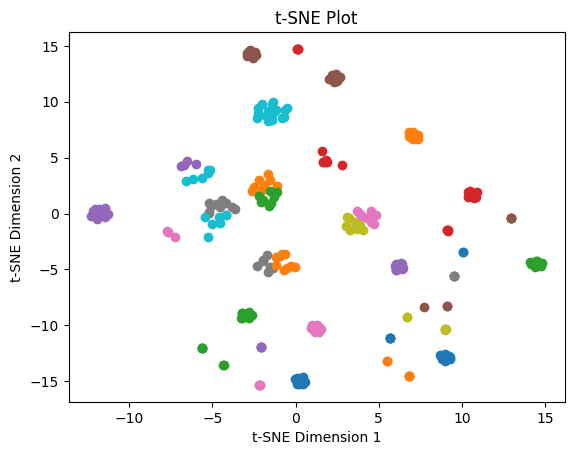

c:\Users\Kiki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Kiki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Kiki\AppData\Local\Temp\ipykernel_15748\1321283516.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[cluster_labels == cluster_id, 0], data[cluster_labels == cluster_id, 1], cmap=cmap)


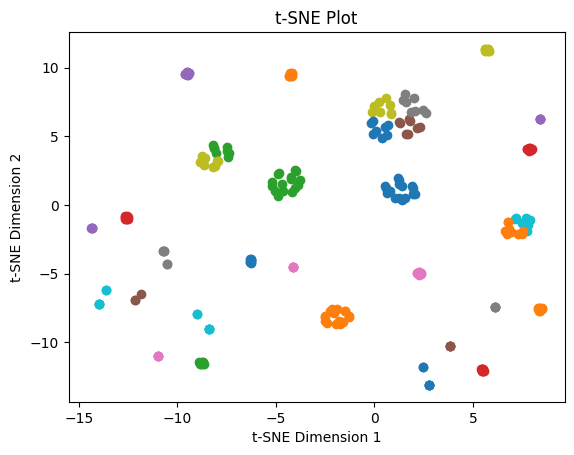

c:\Users\Kiki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Kiki\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Kiki\AppData\Local\Temp\ipykernel_15748\1321283516.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[cluster_labels == cluster_id, 0], data[cluster_labels == cluster_id, 1], cmap=cmap)


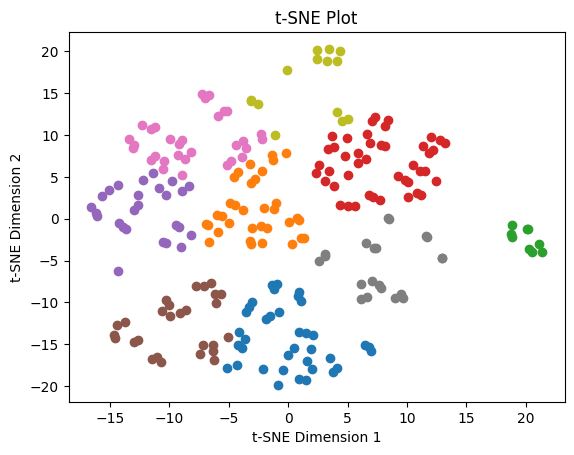

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
tsne = TSNE(2)
x = torch.cartesian_prod(*[torch.tensor([4, 5, 6])]*5)
data = {'x': (x-3).tolist()}
nc = [37, 32, 9]


def plot_tsne(data, nc):
    kmeans = KMeans(n_clusters=nc, init='k-means++',
                    max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(data)
    cmap = plt.get_cmap("tab10")
    for cluster_id in np.unique(cluster_labels):
        plt.scatter(data[cluster_labels == cluster_id, 0],
                    data[cluster_labels == cluster_id, 1], cmap=cmap)
    plt.title('t-SNE Plot')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()


i = 0
for name, mdl in mdls.items():

    with torch.no_grad():
        src = mdl.transformer.embed(x)
        mem = mdl.transformer.encode(src)
    mem = mem.view(mem.shape[0], -1)
    z = tsne.fit_transform(mem)
    plot_tsne(z, nc[i])
    i += 1
    data[name] = z.tolist()
with open('./data/z_embed.dat', 'wb') as f:
    pickle.dump(data, f)


In [ ]:
import numpy as np

# Create two 4x4 NumPy arrays
array1 = np.array([[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12],
                   [13, 14, 15, 16]])

array2 = np.array([[10, 20, 30, 40],
                   [50, 60, 70, 80],
                   [90, 100, 110, 120],
                   [130, 140, 150, 160]])
c = [1]
# Add the arrays element-wise
result = array1 + c * array2

# Print the result
print(result)


[[ 11  22  33  44]
 [ 55  66  77  88]
 [ 99 110 121 132]
 [143 154 165 176]]


In [ ]:
import gc
gc.collect()


10667

In [48]:
import numpy as np
from operator import itemgetter

obss = product(np.array([*range(3)])+4, repeat=5)
outs = product(np.array([*range(2)])+1, repeat=4)
weight = []

speaking_agent = dict()

string_dict = {1: "+",
               2: "-",
               4: "X",
               5: "Y",
               6: "Z"}


with torch.no_grad():
    for name, model in mdls.items():
        obss = product(np.array([*range(3)])+4, repeat=5)
        for obs in obss:
            outs = product(np.array([*range(2)])+1, repeat=4)
            for out in outs:
                inp = np.asarray([obs])
                output = np.asarray(out)
                output = np.append(output, 0)
                logits = model.transformer(torch.tensor(
                    inp), torch.tensor(np.array([output])))[:, -1].numpy()
                exp = np.exp(logits)
                exp_sum = np.sum(exp)
                speaking_agent[(name, "".join(itemgetter(*list(obs))(string_dict)), "".join(itemgetter(*list(out))(string_dict)))] = exp/exp_sum

with open('./data/x_test_noisy_q5.dat', 'wb') as f:
    pickle.dump(speaking_agent, f)

print(speaking_agent)


{('atlas', 'XXXXX', '++++'): array([[0.9541244 , 0.04587565]], dtype=float32), ('atlas', 'XXXXX', '+++-'): array([[0.11728936, 0.8827107 ]], dtype=float32), ('atlas', 'XXXXX', '++-+'): array([[0.14385496, 0.856145  ]], dtype=float32), ('atlas', 'XXXXX', '++--'): array([[0.9189381 , 0.08106193]], dtype=float32), ('atlas', 'XXXXX', '+-++'): array([[0.23725241, 0.7627476 ]], dtype=float32), ('atlas', 'XXXXX', '+-+-'): array([[0.89741683, 0.10258321]], dtype=float32), ('atlas', 'XXXXX', '+--+'): array([[0.8912557 , 0.10874435]], dtype=float32), ('atlas', 'XXXXX', '+---'): array([[0.13032812, 0.8696719 ]], dtype=float32), ('atlas', 'XXXXX', '-+++'): array([[0.13729018, 0.8627098 ]], dtype=float32), ('atlas', 'XXXXX', '-++-'): array([[0.77577984, 0.22422011]], dtype=float32), ('atlas', 'XXXXX', '-+-+'): array([[0.9160771 , 0.08392293]], dtype=float32), ('atlas', 'XXXXX', '-+--'): array([[0.08669572, 0.91330427]], dtype=float32), ('atlas', 'XXXXX', '--++'): array([[0.7976153 , 0.20238474]], d

In [46]:
speaking_agent[('atlas', "XXXXX", "++++")]


array([[0.9541244 , 0.04587565]], dtype=float32)

In [81]:
class ChatBot:
    def __init__(self, speaking_agent: dict, model_names: list = ["atlas", "boreas", "cygnus"]) -> None:
        self.model_names = model_names
        self.speaking_agent = speaking_agent
    
    def query(self, input: str, output: str) -> None:
        for model_name in self.model_names:
            probabilities = self.speaking_agent[model_name, input, output]
            print(f"""Model name: {model_name}
Probability of + is {probabilities[0,0]},
Probability of - is {probabilities[0,1]}""")

In [82]:
chat_bot = ChatBot(speaking_agent)
chat_bot.query('XXXXX', '++++')

AttributeError: 'ChatBot' object has no attribute 'model_name'